# What impact does the noise level have on our "Basic Extraction"

Just a small study

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm, trange
np.random.seed(0)

In [2]:
time_in_ns = np.arange(0, 100, 0.5) # time in ns
pulse_pos_in_ns = 25
integration_window_len = 30 # slices
integration_window_start = 35 # slice index
integration_window_end = 95 # slice index
ns_to_slice_factor = 2
t = time_in_ns[integration_window_start:integration_window_end+integration_window_len]
noise_range = np.arange(1e-7, 10+0.2, 0.2)
fraction_of_events_to_be_correct = 0.997

In [3]:
def fact_pulse_in_mV(x, x0=0):
    from numpy import exp
    p = (1.239*(1-1/(1+exp(((x-x0)-2.851)/1.063)))*exp(-((x-x0)-2.851)/19.173))
    p *= 10
    return p

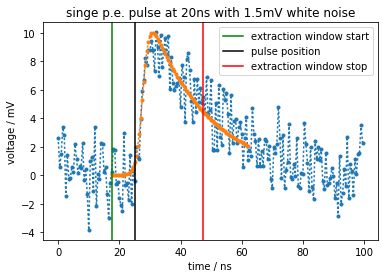

In [4]:
y = fact_pulse_in_mV(time_in_ns, pulse_pos_in_ns)
pure = fact_pulse_in_mV(t, pulse_pos_in_ns)
y += np.random.normal(0, 1.5, size=len(y))

plt.plot(time_in_ns, y, '.:')
plt.plot(t, pure, '.:')
plt.ylabel('voltage / mV')
plt.xlabel('time / ns')
plt.title("singe p.e. pulse at 20ns with 1.5mV white noise")
plt.axvline(time_in_ns[integration_window_start], color='green', label="extraction window start")
plt.axvline(pulse_pos_in_ns, color='black', label="pulse position")
plt.axvline(time_in_ns[integration_window_end], color='red', label="extraction window stop")
plt.legend(loc="upper right")
None

In [5]:
def basic_extraction(data):
    maxPos = np.argmax(data)
    maxHalf = data[maxPos] / 2.
    half_pos = np.where(data[:maxPos+1] < maxHalf)[0]
    if len(half_pos):
        half_pos = half_pos[-1]
    else:
        half_pos = integration_window_start
    integral = data[half_pos:half_pos+30].sum()
    return {
        'arrivalTime': time_in_ns[half_pos + integration_window_start],
        'integral': integral,
    }

In [6]:
gain = basic_extraction(pure)['integral']
true_arrival_time = basic_extraction(pure)['arrivalTime']

In [7]:
def basic_extraction_normalized(data):
    be = basic_extraction(data)
    be['integral'] /= gain
    be['arrivalTime'] -= true_arrival_time
    return be

In [8]:
df = []
true_number_of_photons = 1
for noise in tqdm(noise_range):
    for i in range(1000):
        y = true_number_of_photons * fact_pulse_in_mV(t, pulse_pos_in_ns)
        y += np.random.normal(0, noise, size=len(y))
        d = basic_extraction_normalized(y)
        d['noise'] = noise
        df.append(d)
df = pd.DataFrame(df)
df['reconstructed_number_of_photons'] = df.integral.round().astype(int)
df['correct'] = df.reconstructed_number_of_photons == true_number_of_photons

100%|██████████| 51/51 [00:02<00:00, 24.08it/s]


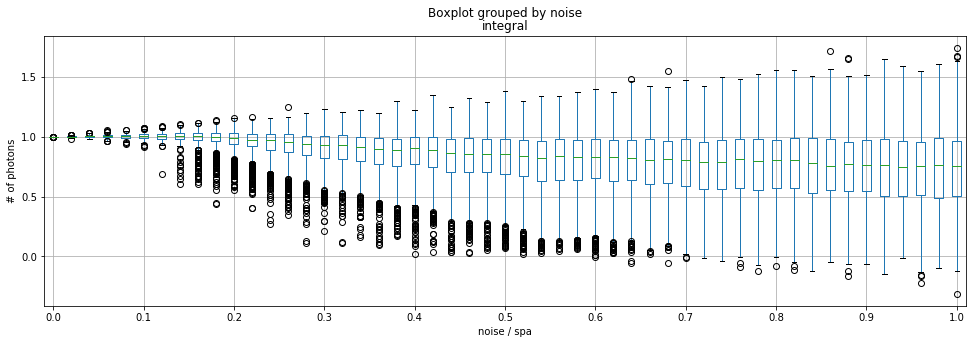

In [9]:
df.boxplot('integral', by='noise', figsize=(16,5))
N = len(noise_range)
idx = np.arange(0, N, 5)
plt.xticks(idx+1, noise_range[idx].round(1) / 10.)
plt.xlabel('noise / spa')
plt.ylabel('# of photons')
None

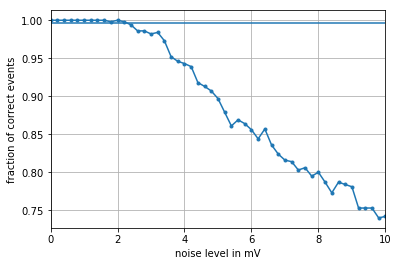

In [10]:
(df.groupby('noise').correct.mean()).plot(marker='.')
plt.grid()
plt.axhline(fraction_of_events_to_be_correct)
plt.ylabel('fraction of correct events')
plt.xlabel('noise level in mV')
None

In [11]:
noise_groups = df.groupby('noise').count().index
A=df.groupby('noise').correct.mean() < fraction_of_events_to_be_correct
noise_groups[A].min()

2.4000001000000002

100%|██████████| 51/51 [00:02<00:00, 24.14it/s]


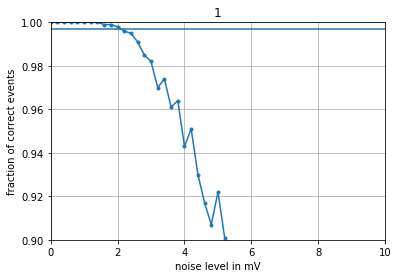

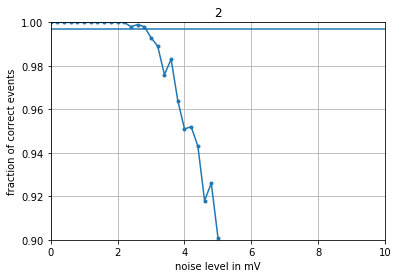

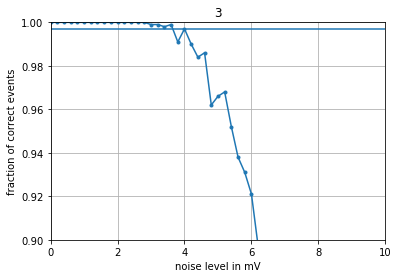

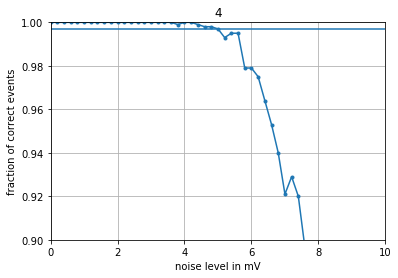

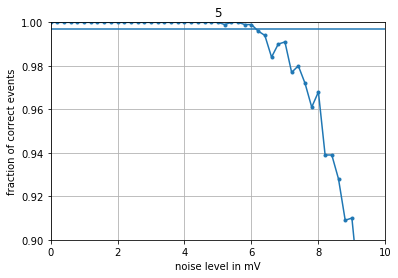

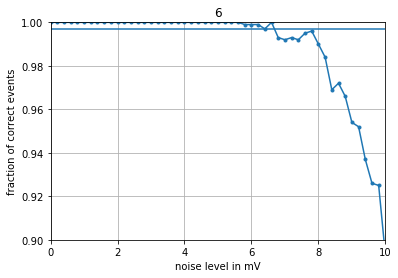

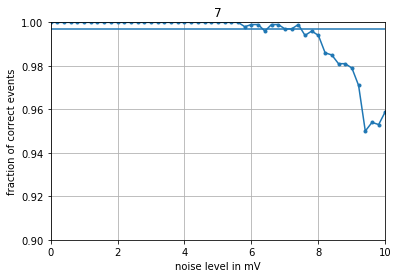

In [12]:
result = []
noise_range = np.arange(1e-7, 10+0.2, 0.2)
for true_number_of_photons in range(1, 8):
    df = []
    for noise in tqdm(noise_range):
        for i in range(1000):
            y = true_number_of_photons * fact_pulse_in_mV(t, pulse_pos_in_ns)
            y += np.random.normal(0, noise, size=len(y))
            d = basic_extraction_normalized(y)
            d['noise'] = noise
            df.append(d)
    df = pd.DataFrame(df)
    df['reconstructed_number_of_photons'] = df.integral.round().astype(int)
    df['correct'] = df.reconstructed_number_of_photons == true_number_of_photons
    B=df.groupby('noise').correct.mean() < fraction_of_events_to_be_correct
    noise_groups = df.groupby('noise').count().index
    
    plt.figure()
    (df.groupby('noise').correct.mean()).plot(marker='.')
    plt.grid()
    plt.axhline(fraction_of_events_to_be_correct)
    plt.ylim(0.9, 1)
    plt.title(str(true_number_of_photons))
    plt.ylabel('fraction of correct events')
    plt.xlabel('noise level in mV')

    result.append({
        'true_number_of_photons':true_number_of_photons,
        'max_allowed_noise': noise_groups[B].min(),
    })
result = pd.DataFrame(result)
result.set_index('true_number_of_photons', inplace=True)

In [13]:
result

,max_allowed_noise
true_number_of_photons,
1,2.2
2,3.0
3,3.8
4,5.2
5,6.2
6,6.8
7,6.4


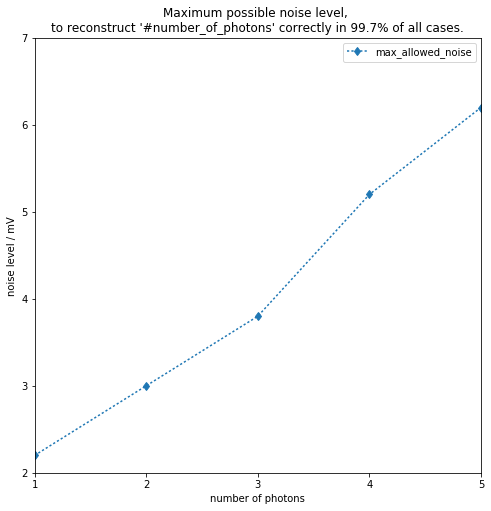

In [14]:
result.plot(marker='d', figsize=(8,8), linestyle=':')
plt.ylabel('noise level / mV')
plt.xlim(1, 5)
plt.xticks(np.arange(1,6))
plt.ylim(2, 7)
plt.xlabel('number of photons')
plt.title("""Maximum possible noise level, 
to reconstruct '#number_of_photons' correctly in {0:.1f}% of all cases.""".format(fraction_of_events_to_be_correct*100))